In [77]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

In [78]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

In [79]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [80]:
PATH = 'flowers_dataset'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [81]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [82]:
class_names = train_dataset.class_names

In [83]:
class_names

['flowers', 'not_flowers']

In [84]:
validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


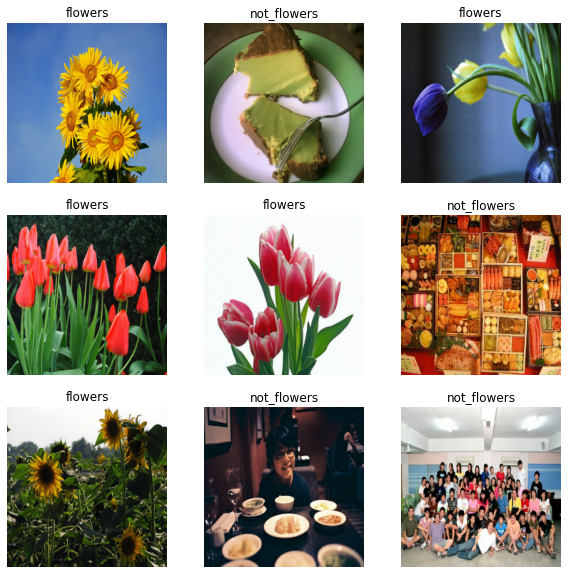

In [85]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [86]:
test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             )

Found 700 files belonging to 2 classes.


In [87]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [88]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.3)
    ]
)

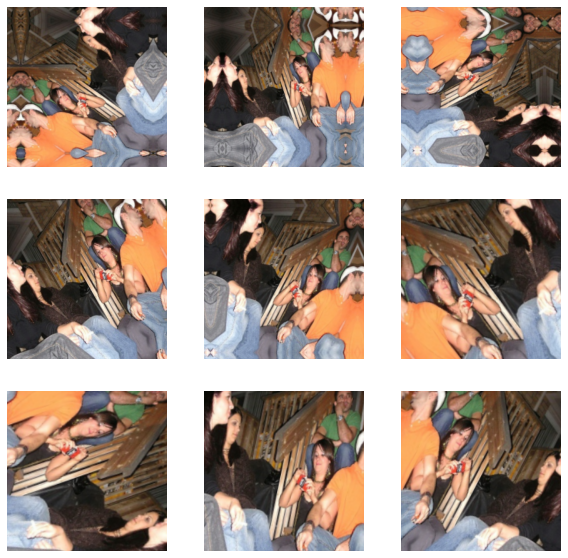

In [89]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [90]:
rescale = preprocessing.Rescaling(1./255)

In [91]:
# AlexNet
# AlexNet variation implementation with Functional API in Tensorflow 2
def AlexNet():
    inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
    x = data_augmentation(inputs)
    x = rescale(x)
    x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name='AlexNet')
    return model

In [92]:
model_alexnet = AlexNet()

In [93]:
model_alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_302 (Conv2D)         (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_303 (Conv2D)         (None, 30, 30, 256)       614656    
                                                           

In [94]:
model_alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0003),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [95]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [96]:
history_alexnet = model_alexnet.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/10
75/75 [==============================] - 144s 2s/step - loss: 2.1968 - accuracy: 0.5783 - val_loss: 1.2726 - val_accuracy: 0.5500
Epoch 2/10
75/75 [==============================] - 163s 2s/step - loss: 0.8914 - accuracy: 0.6617 - val_loss: 0.7124 - val_accuracy: 0.6083
Epoch 3/10
75/75 [==============================] - 175s 2s/step - loss: 0.7240 - accuracy: 0.6883 - val_loss: 0.6764 - val_accuracy: 0.5950
Epoch 4/10
75/75 [==============================] - 190s 3s/step - loss: 0.6083 - accuracy: 0.7325 - val_loss: 0.8443 - val_accuracy: 0.6083
Epoch 5/10
75/75 [==============================] - 165s 2s/step - loss: 0.5513 - accuracy: 0.7663 - val_loss: 0.6201 - val_accuracy: 0.6033
Epoch 6/10
75/75 [==============================] - 156s 2s/step - loss: 0.4937 - accuracy: 0.7800 - val_loss: 0.5331 - val_accuracy: 0.7983
Epoch 7/10
75/75 [==============================] - 149s 2s/step - loss: 0.4905 - accuracy: 0.7725 - val_loss: 0.5840 - val_accuracy: 0.6967
Epoch 8/10
75

In [97]:
def plotLearningCurve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

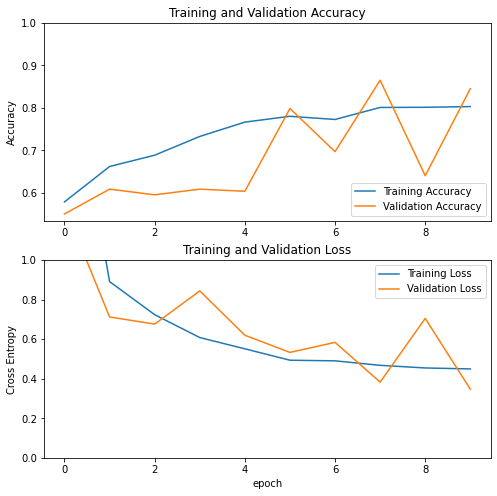

In [98]:
plotLearningCurve(history_alexnet)

In [99]:
model_alexnet.evaluate(test_dataset)

22/22 [==============================] - 10s 433ms/step - loss: 0.3985 - accuracy: 0.8229


[0.3985483646392822, 0.822857141494751]

We are getting 67.33% accuracy with validation data and 62.26% accuracy with test data. Which is not very encouraging. We could achieve more if we did tuning or had more data.

## Transfer learning with Pre-Trained VGG19

In [100]:
base_model_vgg19 = tf.keras.applications.vgg19.VGG19(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [101]:
base_model_vgg19.trainable = False

In [102]:
inputs = tf.keras.Input(shape=(256,256,3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.vgg19.preprocess_input(x)
x = base_model_vgg19(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_vgg19 = tf.keras.Model(inputs, outputs, name='vgg19')

In [103]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d_4   (None, 512)              0     

In [104]:
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [105]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [106]:
history_vgg19 = model_vgg19.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/10
75/75 [==============================] - 649s 9s/step - loss: 0.3755 - accuracy: 0.9183 - val_loss: 0.1543 - val_accuracy: 0.9750
Epoch 2/10
75/75 [==============================] - 641s 9s/step - loss: 0.1696 - accuracy: 0.9554 - val_loss: 0.1296 - val_accuracy: 0.9750
Epoch 3/10
75/75 [==============================] - 679s 9s/step - loss: 0.1393 - accuracy: 0.9550 - val_loss: 0.1308 - val_accuracy: 0.9783
Epoch 4/10
75/75 [==============================] - 645s 9s/step - loss: 0.1416 - accuracy: 0.9538 - val_loss: 0.0848 - val_accuracy: 0.9733
Epoch 5/10
75/75 [==============================] - 637s 9s/step - loss: 0.1077 - accuracy: 0.9658 - val_loss: 0.0806 - val_accuracy: 0.9733
Epoch 6/10
75/75 [==============================] - 640s 9s/step - loss: 0.0902 - accuracy: 0.9712 - val_loss: 0.1046 - val_accuracy: 0.9733
Epoch 7/10
75/75 [==============================] - 648s 9s/step - loss: 0.0701 - accuracy: 0.9746 - val_loss: 0.0903 - val_accuracy: 0.9833


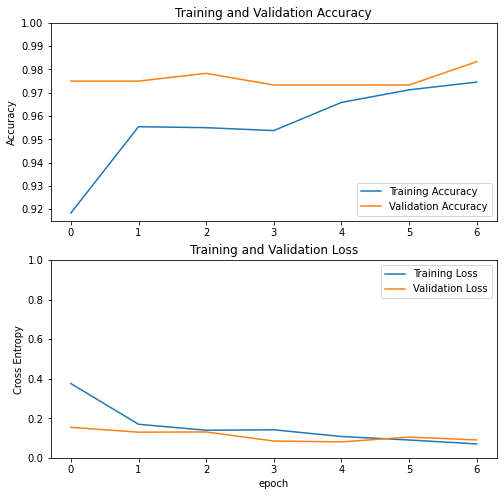

In [107]:
plotLearningCurve(history_vgg19)

In [108]:
model_vgg19.save('model_vgg19.h5')

In [109]:
model_vgg19.evaluate(test_dataset)

22/22 [==============================] - 150s 7s/step - loss: 0.0671 - accuracy: 0.9686


[0.06711044162511826, 0.9685714244842529]

## Transfer learning with Pre-Trained ResNet50

In [110]:
base_model_resnet50 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [111]:
base_model_resnet50.trainable = False


In [112]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model_resnet50(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_resnet50 = tf.keras.Model(inputs, outputs, name='resnet50')

In [113]:
model_resnet50.summary()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0  

In [114]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [115]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [116]:
history_resnet50 = model_resnet50.fit(train_dataset,
                        epochs=10,
                        validation_data=validation_dataset,
                        callbacks=[callback])

Epoch 1/10
75/75 [==============================] - 245s 3s/step - loss: 0.1986 - accuracy: 0.9271 - val_loss: 0.0436 - val_accuracy: 0.9800
Epoch 2/10
75/75 [==============================] - 250s 3s/step - loss: 0.0959 - accuracy: 0.9638 - val_loss: 0.0619 - val_accuracy: 0.9850
Epoch 3/10
75/75 [==============================] - 251s 3s/step - loss: 0.0686 - accuracy: 0.9700 - val_loss: 0.0426 - val_accuracy: 0.9883
Epoch 4/10
75/75 [==============================] - 257s 3s/step - loss: 0.0557 - accuracy: 0.9787 - val_loss: 0.0428 - val_accuracy: 0.9883
Epoch 5/10
75/75 [==============================] - 263s 4s/step - loss: 0.0510 - accuracy: 0.9804 - val_loss: 0.0657 - val_accuracy: 0.9867


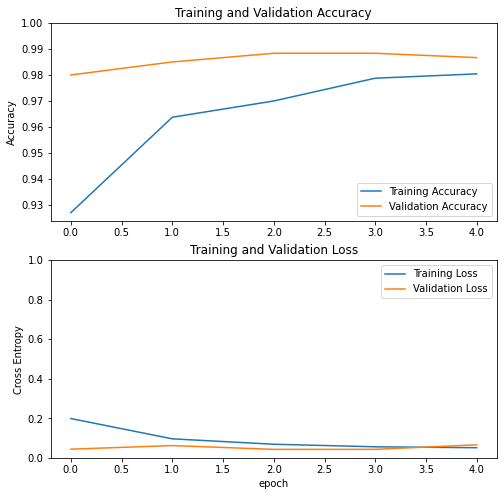

In [117]:
plotLearningCurve(history_resnet50)

In [118]:
model_resnet50.save('model_resnet50.h5')

In [119]:
model_resnet50.evaluate(test_dataset)

22/22 [==============================] - 59s 3s/step - loss: 0.0718 - accuracy: 0.9729


[0.07184278219938278, 0.9728571176528931]

## Transfer learning with Pre-Trained Inception V3

In [120]:
base_model_inception_v3 = tf.keras.applications.inception_v3.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [121]:
base_model_inception_v3.trainable = False

In [122]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model_inception_v3(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_v3 = tf.keras.Model(inputs, outputs, name='inception_v3')

In [123]:
model_inception_v3.summary()

Model: "inception_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_6   (None, 2048)            

In [124]:
model_inception_v3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [125]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [126]:
history_inception_v3 = model_inception_v3.fit(train_dataset,
                            epochs=10,
                            validation_data=validation_dataset,
                            callbacks=[callback])

Epoch 1/10
75/75 [==============================] - 168s 2s/step - loss: 0.3074 - accuracy: 0.8975 - val_loss: 0.0734 - val_accuracy: 0.9833
Epoch 2/10
75/75 [==============================] - 154s 2s/step - loss: 0.1730 - accuracy: 0.9350 - val_loss: 0.1029 - val_accuracy: 0.9450
Epoch 3/10
75/75 [==============================] - 154s 2s/step - loss: 0.1503 - accuracy: 0.9438 - val_loss: 0.0602 - val_accuracy: 0.9850
Epoch 4/10
75/75 [==============================] - 162s 2s/step - loss: 0.1258 - accuracy: 0.9517 - val_loss: 0.0746 - val_accuracy: 0.9717
Epoch 5/10
75/75 [==============================] - 158s 2s/step - loss: 0.1042 - accuracy: 0.9621 - val_loss: 0.0652 - val_accuracy: 0.9817


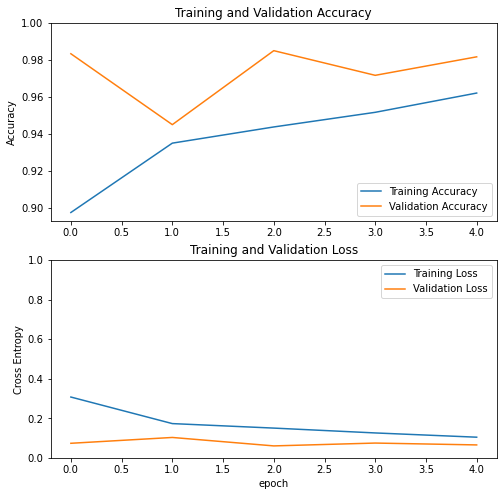

In [127]:
plotLearningCurve(history_inception_v3)

In [128]:
model_inception_v3.save('model_inception_v3.h5')

In [129]:
model_inception_v3.evaluate(test_dataset)

22/22 [==============================] - 36s 2s/step - loss: 0.0686 - accuracy: 0.9757


[0.06855368614196777, 0.9757142663002014]

## Transfer learning with Pre-Trained Inception ResNet V2

In [130]:
base_model_inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [131]:
base_model_inception_resnet_v2.trainable = False

In [132]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model_inception_resnet_v2(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_resnet_v2 = tf.keras.Model(inputs, outputs, name='inception_resnet_v2')

In [133]:
model_inception_resnet_v2.summary()

Model: "inception_resnet_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                               

In [134]:
model_inception_resnet_v2.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                              metrics=['accuracy'])

In [135]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [136]:
history_inception_resnet_v2 = model_inception_resnet_v2.fit(train_dataset,
                                    epochs=10,
                                    validation_data=validation_dataset,
                                    callbacks=[callback])

Epoch 1/10
75/75 [==============================] - 728s 10s/step - loss: 0.2524 - accuracy: 0.9183 - val_loss: 0.0840 - val_accuracy: 0.9767
Epoch 2/10
75/75 [==============================] - 588s 8s/step - loss: 0.1118 - accuracy: 0.9546 - val_loss: 0.0879 - val_accuracy: 0.9600
Epoch 3/10
75/75 [==============================] - 587s 8s/step - loss: 0.1199 - accuracy: 0.9571 - val_loss: 0.0788 - val_accuracy: 0.9700
Epoch 4/10
75/75 [==============================] - 549s 7s/step - loss: 0.1106 - accuracy: 0.9567 - val_loss: 0.0818 - val_accuracy: 0.9683
Epoch 5/10
75/75 [==============================] - 564s 8s/step - loss: 0.1139 - accuracy: 0.9588 - val_loss: 0.0854 - val_accuracy: 0.9700


In [137]:
model_inception_resnet_v2.save('model_inception_resnet_v2.h5')

In [138]:
model_inception_resnet_v2.evaluate(test_dataset)

22/22 [==============================] - 131s 6s/step - loss: 0.0762 - accuracy: 0.9700


[0.07616173475980759, 0.9700000286102295]

## Transfer learning with Pre-Trained MobileNet

In [139]:
base_model_mobilenet_v2 = tf.keras.applications.mobilenet_v2.MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

In [140]:
base_model_mobilenet_v2.trainable = False

In [141]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model_mobilenet_v2(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_mobilenet_v2 = tf.keras.Model(inputs, outputs, name='mobilenet_v2')

In [142]:
model_mobilenet_v2.summary()

Model: "mobilenet_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                      

In [143]:
model_mobilenet_v2.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                              metrics=['accuracy'])

In [144]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [145]:
history_mobilenet_v2 = model_mobilenet_v2.fit(train_dataset,
                                    epochs=10,
                                    validation_data=validation_dataset,
                                    callbacks=[callback])

Epoch 1/10
75/75 [==============================] - 98s 1s/step - loss: 0.1966 - accuracy: 0.9242 - val_loss: 0.0982 - val_accuracy: 0.9783
Epoch 2/10
75/75 [==============================] - 95s 1s/step - loss: 0.1200 - accuracy: 0.9550 - val_loss: 0.0868 - val_accuracy: 0.9767
Epoch 3/10
75/75 [==============================] - 89s 1s/step - loss: 0.1007 - accuracy: 0.9638 - val_loss: 0.1001 - val_accuracy: 0.9750
Epoch 4/10
75/75 [==============================] - 90s 1s/step - loss: 0.1086 - accuracy: 0.9596 - val_loss: 0.0769 - val_accuracy: 0.9800
Epoch 5/10
75/75 [==============================] - 88s 1s/step - loss: 0.0838 - accuracy: 0.9667 - val_loss: 0.0754 - val_accuracy: 0.9750
Epoch 6/10
75/75 [==============================] - 89s 1s/step - loss: 0.0879 - accuracy: 0.9658 - val_loss: 0.0823 - val_accuracy: 0.9733
Epoch 7/10
75/75 [==============================] - 123s 2s/step - loss: 0.0600 - accuracy: 0.9750 - val_loss: 0.0965 - val_accuracy: 0.9783


In [146]:
model_mobilenet_v2.save('model_mobilenet_v2.h5')

C:\Users\crazyguy\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [147]:
model_mobilenet_v2.evaluate(test_dataset)

22/22 [==============================] - 25s 1s/step - loss: 0.0572 - accuracy: 0.9786


[0.05716193467378616, 0.9785714149475098]

In [153]:
loss_alexnet, acc_alexnet = model_alexnet.evaluate(test_dataset)
loss_vgg19, acc_vgg19 = model_vgg19.evaluate(test_dataset)
loss_resnet50, acc_resnet50 = model_resnet50.evaluate(test_dataset)
loss_inception_v3, acc_inception_v3 = model_inception_v3.evaluate(test_dataset) 
loss_inception_resnet_v2, acc_inception_resnet_v2 = model_inception_resnet_v2.evaluate(test_dataset)
loss_mobilenet_v2, acc_mobilenet_v2 = model_mobilenet_v2.evaluate(test_dataset)

22/22 [==============================] - 27s 1s/step - loss: 0.0572 - accuracy: 0.9786


In [156]:
print("Alexnet_accuracy: ", acc_alexnet*100)
print("Vgg19_accuracy: ", acc_vgg19*100)
print("Resnet50_accuracy: ", acc_resnet50*100)
print("Inception_v3_accuracy: ", acc_inception_v3*100)
print("Inception_resnet_v2_accuracy: ", acc_inception_resnet_v2*100)
print("Mobilenet_v2_accuracy: ", acc_mobilenet_v2*100)

Alexnet_accuracy:  82.2857141494751
Vgg19_accuracy:  96.8571424484253
Resnet50_accuracy:  97.2857117652893
Inception_v3_accuracy:  97.57142663002014
Inception_resnet_v2_accuracy:  97.00000286102295
Mobilenet_v2_accuracy:  97.85714149475098
